<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_10%5DLet's_make_a_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_10]Let's make a translator

## 1.import 및 데이터로드

In [ ]:
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# !pip install --upgrade tensorflow

### 1) Import

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt

### 2) 데이터로드

In [ ]:
file_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/translator_seq2seq/fra.txt"
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플수:',len(lines))
lines.sample(5)

전체 샘플수: 194513


,eng,fra,cc
39166,We're finally alone.,Nous sommes enfin seuls.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
60433,Who else went with Tom?,Qui d'autre est allé avec Tom ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
119701,You look good in those clothes.,Tu as belle allure dans ces vêtements.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
61383,Are you sure it was Tom?,Es-tu sûr que c'était Tom ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
120193,Be careful. That knife is sharp.,Sois prudent. Ce couteau est aiguisé.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...



데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다

In [ ]:
lines = lines[['eng', 'fra']][:33000]
lines.sample(5)

,eng,fra
171,Be nice.,Soyez gentilles !
13752,How old are you?,Quel âge as-tu ?
13663,He's a southpaw.,C'est un gaucher.
27491,You can have both.,Vous pouvez avoir les deux.
27231,Where did they go?,Où sont-ils passés ?


## 2. 데이터 전처리 작업


### 1)  정제, 정규화 & 케라스의 토크나이저로 텍스트를 숫자로 & 디코더 문장에 시작 토큰과 종료 토큰 입력

- 구두점(Punctuation)을 단어와 분리
- 소문자로 change
- 띄어쓰기 단위로 토큰을 수행
  - (토크나이저에 옵션을 줌으로 텍스트 숫자로 변환과 동시진행 가능)
  - (디코더 문장의 경우 토크나이저 직전에 시작 토큰과 종료 토큰 입력 가능)

In [ ]:
# import re
# def preprocess_sentence(sentence):
#     sentence = sentence.str.extract.lower() # 1 소문자로 바꾸고
#     sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2 특수문자 양쪽에 공백을 넣는다.
#     sentence = re.sub(r'[" "]+', " ", sentence) # 3 여러개의 공백은 하나의 공백으로 바꾼다.
#     sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다. 
#     tokenizer  = Tokenizer(split=' ')  
#     tokenizer .fit_on_texts(sentence)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
#     sentence = tokenizer.texts_to_sequences(sentence) 
#     return sentence

- 참고 자료
  - DataFrame 정규표현식 적용 : https://acdongpgm.tistory.com/166
    - 기존에 사용했던 import re를 사용하니 type 오류가 발생함, 그리고 출력값이 이사하게 나옴
  - 토크나이저 : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [ ]:
def preprocess_sentence(sentence):
  sentence = sentence.str.lower()
  sentence = sentence.str.replace(pat=r'([?.!,¿])', repl =r" \1",regex=True)
  sentence = sentence.str.replace(pat=r'[" "]+', repl =" ",regex=True)
  sentence = sentence.str.replace(pat=r"[^a-zA-Z!.?]+", repl =" ",regex=True)
  sentence = sentence.str.strip() 

  return sentence

In [ ]:
input_text = preprocess_sentence(lines.eng)
eng_tokenizer = Tokenizer(split=' ', filters="")   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(input_text)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(input_text)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[29, 1], [29, 1], [29, 1]]

In [ ]:
target_text = preprocess_sentence(lines.fra)
print(target_text)
# 디코더에 시작 토큰과 종료토큰 추가
sos_token = '\t'
eos_token = '\n'
target_text= target_text.apply(lambda x : '\t '+ x + ' \n')
print(target_text)

fra_tokenizer = Tokenizer(split=' ', filters="")   # 문자 단위로 Tokenizer를 생성|합니다. 
fra_tokenizer.fit_on_texts(target_text)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(target_text)    # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

0                              va !
1                          marche .
2                           bouge !
3                           salut !
4                           salut .
                    ...            
32995     qu est ce que tom a vol ?
32996    qu est ce que tom a crit ?
32997           que voulaient ils ?
32998         que voulaient elles ?
32999                 qu as tu bu ?
Name: fra, Length: 33000, dtype: object
0                              \t va ! \n
1                          \t marche . \n
2                           \t bouge ! \n
3                           \t salut ! \n
4                           \t salut . \n
                       ...               
32995     \t qu est ce que tom a vol ? \n
32996    \t qu est ce que tom a crit ? \n
32997           \t que voulaient ils ? \n
32998         \t que voulaient elles ? \n
32999                 \t qu as tu bu ? \n
Name: fra, Length: 33000, dtype: object


[[1, 75, 8, 2], [1, 378, 3, 2], [1, 718, 8, 2]]

- 토크나이저를 할때 계속 불용어가 제거되고 토크나이저를 진행됨
  - 공식문서를 확인해본 결과 filters에 자동으로 불용어가 제거되도록 되어 있음
  - 그래서 filters=""를 하여 아무것도 제거하지 않도록 지정하였음

### 2) 임베딩층 구현을 위한 전처리

#### (1) vocab_size 구하기

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4673
프랑스어 단어장의 크기 : 7462


#### (2) 교사강요 위한 전처리
- 디코더의 출력과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것입니다. 
  - < sos >가 필요 없음
- 이전 스텝에서 언급했던 교사 강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위한 것
  - < eos >토큰이 필요 없음

In [ ]:
# input encoder 지정
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 

# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [ ]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 75, 8], [1, 378, 3], [1, 718, 8]]
[[75, 8, 2], [378, 3, 2], [718, 8, 2]]


#### (3) maxlen 구하기

In [ ]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in decoder_target])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


- 길이가 안맞아서 계속 오류가 생겼었다. 
  - 시작 토큰과 종료토큰중 하나만 들어가 있는 길이를 계산해야 된다. 이유는 학습할 때는 결국 둘중 하나는 없는 데이터로 하기 때문이다.
  - 나는 계속해서 한 개의 토큰을 제거하기전에 계산한 길이로 학습을 했기 때문에 계속해서 오류가 발생하였다.

#### (4) 패딩

In [ ]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [ ]:
print(encoder_input[0])
print(decoder_input[0])
print(decoder_target[0])

[29  1  0  0  0  0  0  0]
[ 1 75  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
[75  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0]


#### (5) 원-핫 인코딩
-  각 정수에 대해서 벡터화 방법으로 원-핫 인코딩을 선택
-  데이터의 크기는 (샘플의 수 × 샘플의 길이 × 단어장의 크기)가 된다.
-  원-핫 인코딩은 각 정수를 단어장의 크기를 가지는 원-핫 벡터로 인코딩하는 과정

In [ ]:
# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
# print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
# print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
# print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

> 단어사전이 너무 커서 세션이 계속해서 종료됨 그래서 사용하지 않기로 함

#### (6) 학습데이터 검증 데이터 분리

In [ ]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 16)


## 5. 임베딩 층(Embedding layer) 사용하기
- https://wikidocs.net/33793
- 주의할 점 : 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만 디코더의 훈련 과정과 테스트 과정에서의 임베딩층은 동일해야 한다.

In [ ]:
embedding_dim = 128
hidden_units = 256

In [ ]:
# 인코더
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None,))

# 임베딩 레이어 사용
encoder_embedding = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) 

# 패딩 0 제외
encoder_embedding_masking = Masking(mask_value=0.0)(encoder_embedding) 

# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(hidden_units, return_state=True) 

# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_masking) 

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c] 

In [ ]:
# 디코더
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))

# 임베딩 레이어 사용
decoder_embedding_layer = Embedding(fra_vocab_size, hidden_units)

decoder_embedding = decoder_embedding_layer(decoder_inputs) 

# 패딩 0 제외
decoder_masking = Masking(mask_value=0.0)(decoder_embedding)

# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _ = decoder_lstm(decoder_masking, initial_state=encoder_states)

## 6. 모델 구현하기

### 1) 모델 구현 및 학습

In [ ]:
# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=20)

Epoch 1/20
235/235 [==============================] - 22s 41ms/step - loss: 2.3441 - accuracy: 0.6650 - val_loss: 1.9858 - val_accuracy: 0.7015
Epoch 2/20
235/235 [==============================] - 7s 30ms/step - loss: 1.6050 - accuracy: 0.7418 - val_loss: 1.8204 - val_accuracy: 0.7169
Epoch 3/20
235/235 [==============================] - 7s 31ms/step - loss: 1.4309 - accuracy: 0.7618 - val_loss: 1.6696 - val_accuracy: 0.7374
Epoch 4/20
235/235 [==============================] - 7s 31ms/step - loss: 1.2847 - accuracy: 0.7818 - val_loss: 1.5521 - val_accuracy: 0.7541
Epoch 5/20
235/235 [==============================] - 7s 31ms/step - loss: 1.1519 - accuracy: 0.8005 - val_loss: 1.4445 - val_accuracy: 0.7688
Epoch 6/20
235/235 [==============================] - 7s 31ms/step - loss: 1.0394 - accuracy: 0.8157 - val_loss: 1.3677 - val_accuracy: 0.7830
Epoch 7/20
235/235 [==============================] - 7s 31ms/step - loss: 0.9483 - accuracy: 0.8271 - val_loss: 1.3076 - val_accuracy: 0.790

### 2) 그래프

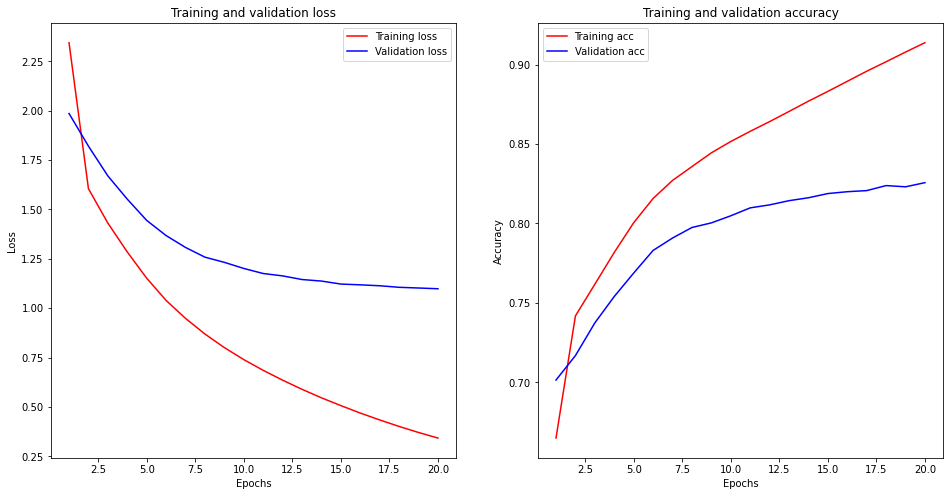

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

## 7. 모델 평가하기

### 1) 평가 모델 구현

In [ ]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         598144    
                                                                 
 masking (Masking)           (None, None, 128)         0         
                                                                 
 lstm (LSTM)                 [(None, 256),             394240    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 992,384
Trainable params: 992,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_units,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 임베딩 레이어 문제인듯 한데
decoder_embedding2 = decoder_embedding_layer(decoder_inputs) 

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding2, initial_state = decoder_states_inputs)

# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states2 = [state_h2, state_c2]

In [ ]:
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1910272     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

### 2) 함수 구현
> ecode_sequence()의 입력으로 들어가는 것은 번역하고자 하는 문장의 정수 시퀀스입니다. decode_sequence() 내부에는 인코더를 구현한 encoder_model이 있어서 이 모델에 번역하고자 하는 문장의 정수 시퀀스인 'input_seq'를 입력하면, encoder_model은 마지막 시점의 hidden state를 리턴합니다.

> 이 hidden state는 디코더의 첫번째 시점의 hidden state가 되고, 디코더는 이제 번역 문장을 완성하기 위한 예측 과정을 진행합니다. 디코더의 예측 과정에서는 이전 시점에서 예측한 단어를 디코더의 현재 시점의 입력으로 넣어주는 작업을 진행합니다. 그리고 이 작업은 종료를 의미하는 종료 토큰을 만나거나, 주어진 최대 길이를 넘을 때까지 반복합니다.

> seq_to_src 함수는 영어 문장에 해당하는 정수 시퀀스를 입력받으면 정수로부터 영어 단어를 리턴하는 index_to_src를 통해 영어 문장으로 변환
<br> seq_to_tar은 프랑스어에 해당하는 정수 시퀀스를 입력받으면 정수로부터 프랑스어 단어를 리턴하는 index_to_tar을 통해 프랑스어 문장으로 변환

In [ ]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [ ]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = fra2idx['\t']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = idx2fra[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '\n' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + idx2eng[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra2idx['\t'] and encoded_word != fra2idx['\n']):
      sentence = sentence + idx2fra[encoded_word] + ' '
  return sentence

### 3) 번역 시행

In [ ]:
# 출력 결과 테스트하기
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : hi . 
정답문장 : salut ! 
번역문장 : salu
--------------------------------------------------
입력문장 : hello ! 
정답문장 : salut ! 
번역문장 : relax
--------------------------------------------------
입력문장 : hop in . 
정답문장 : montez . 
번역문장 : monte
--------------------------------------------------
입력문장 : help me ! 
정답문장 : aide moi ! 
번역문장 : aide mo
--------------------------------------------------
입력문장 : humor tom . 
정답문장 : mettez tom de bonne humeur . 
번역문장 : nettoyez to
--------------------------------------------------


In [ ]:
for seq_index in [5, 30, 100, 370, 700]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : i want to be clear . 
정답문장 : je veux tre clair . 
번역문장 : je veux que je te voir 
--------------------------------------------------
입력문장 : i want to sit down . 
정답문장 : je veux m asseoir . 
번역문장 : je veux que vous en m m
--------------------------------------------------
입력문장 : i was very nervous . 
정답문장 : j tais tr s nerveuse . 
번역문장 : j tais tr s bie
--------------------------------------------------
입력문장 : i m not photogenic . 
정답문장 : je ne suis pas photog nique . 
번역문장 : je ne suis pas enseignan
--------------------------------------------------
입력문장 : it s a bad example . 
정답문장 : c est un mauvais exemple . 
번역문장 : c est un mauvais gar o
--------------------------------------------------


## 8. 회고
> ### 1. 어려웠던 점
- 전처리 과정이 type이 달라서 import re가 잘 적용이 되지 않아 어려움을 겪었었지만 DataFrame용으로 정규표현식을 사용하는 방법을 찾아서 잘 해결할 수 있었다.
- Functional API 임베딩층 구현이 생소하였으나 fd와 링크를 참조하여 잘 해결 할 수 있었다.
- 최대 문장 길이를 뽑는 시점을 잘 못 맞춰 오류로 고생하였으나 코드를 차근차근 다시 뜯어 보면서 문제를 해결할 수 있었다.
- 토크나이저를 진행할 때 filters가 디폴트 값으러 설정되어 있어 \t, \n이 계속 삭제 되었다. 그래서 공식문서를 확인하로 filters=""로 바꿔주어 이 문제를 해결할 수 있었다.

> ### 2. 루브릭 기준을 맞추기 위해서 시도한 것
- 최적의 시점에 epoch를 종료하여 val_loss가 우하향 그래프를 그릴 수 있었다.
- 구두점 분리, 소문자 변환, 띄어쓰기 단위별 토크나이저를 진행하였고 추가적으로 기타 다른 기호는 공백으로 처리 및 여러 공백은 하나의 공백으로 처리 및 최종적으로 양쪽 끝 공백을 제거해주는 작업을 진해하였다.
- 정확도를 올리고 loss를 줄이기 위해서 embedding_dim과 hidden_unit 값을 상향 조정해 주었다.

> ### 3. 오류
- 모델 학습전 원-핫 인코딩을 시도하였으나 영어와 프랑스어 단어장 크기가 너무 커서 세션에 계속 종료가 되었다. 그래서 GPU 말고 TPU로도 시도를 해보았으나 계속 종료가 되어 원-핫 인코딩을 안하고 코드를 적용하기로 하였다.

> ### 4. 익스 10을 마치며
지금껏 진행했던 프로젝트중 가장 어려웠던 것 같다. 이전 프로젝트는 LMS만 그대로 이해하고 따라하면 90%는 할 수 있었으나 이번 프로젝트는 조금 꼬아서 문제를 주신 것 같다. 그런 만큼 더 많이 고민하고 더 많이 시행착오를 거쳐 확실히 공부가 되었던 것 같다.